In [1]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# VADER sentiment analysis algorithm
from nltk.sentiment import SentimentIntensityAnalyzer

from scipy.stats import pearsonr
import datetime
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from util import *

# coherence maximization
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
with open("pkl/preprocessed_bitcoin.pkl", 'rb') as f:
    data = pickle.load(f)

voca2idx = {w: i for i, w in enumerate(data['voca'])}
voca = data['voca']

bow_tdm = load('bow_tdm')
price_dict = load('price_dict')
prices_list = load('prices_list')

In [13]:
prices_list = []
# format
# Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
with open("data/BTC/price/bitcoin_price.csv") as f:
    next(f)
    for i, line in enumerate(f):
        price = {}
        line = line[:-1]
        timestamp, open_, high, low, close, volume, market_cap, weighted_price = line.split(',')
        price['date'] = datetime.date.fromtimestamp(int(timestamp))
        price['open'] = float(open_.replace(',', ''))
        price['high'] =  float(high.replace(',', ''))
        price['low'] =  float(low.replace(',', ''))
        price['close'] =  float(close.replace(',', ''))
        try:
            price['volume'] =  float(volume.replace(',', ''))
        except:
            break
        price['market_cap'] =  float(market_cap.replace(',', ''))
        prices_list.append(price)
        
prices_list.reverse()
# prices_list = prices_list[521:-27] # Feb 02, 2018까지
# print(len(prices_list))

In [10]:
time_list = sorted(list(data['time_posts'].keys()))
# time period fixed here
time_list = [t for t in time_list if t>= datetime.datetime(2016, 6, 1).date()]

In [5]:

# m by n, or number of documents (tweets) by length of corpus (unique words)
bow_tdm = np.zeros((len(time_list), len(voca)), dtype=np.float32)
for i, time in enumerate(time_list):

    for post in data['time_posts'][time]:
        for word in post:
            bow_tdm[i, voca2idx[word]] += 1
            
bow_tdm = normalize(bow_tdm)

In [6]:
bow_tdm.shape

(1155, 70401)

In [7]:
# dictionary = corpora.Dictionary()


# gensim_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

In [7]:
# fix the length of the prices_list so that it matches the number of documents or posts
# i.e. fix the prices to one price per day
price_dict = {}
# price_dict

for dict in prices_list:
    if dict['date'] in time_list and not(np.isnan(dict['high'])):
        price_dict[dict['date']] = dict['high']


In [9]:
# tf_idf not terribly effective for this dataset  

# tfidf_transformer = TfidfTransformer()
# tf_idf_tdm = tfidf_transformer.fit_transform(bow_tdm)

# del bow_tdm

In [5]:
K = 10
# 1 over the number of documents
# alpha_W = 1/tf_idf_tdm.shape[0]
# alpha_H = 1/tf_idf_tdm.shape[0]
alpha_W = 0
alpha_H = 0
max_iter = 500
alpha=0.1

def get_fitted_output(tdm, K, method="nmf"):

    # Non-negative Matrix Factorization
    if method == 'nmf':
        # sklearn NMF
        nmf = NMF(init='nndsvd', n_components=K, alpha_H=alpha_H, alpha_W=alpha_W, max_iter=max_iter)
        W = nmf.fit_transform(tdm).T
        H = nmf.components_
        return W, H

        # Latent Dirichlet Allocation (takes much longer)
    elif method == 'lda':
        # Gensim model
        # lda_model = gensim.models.ldamodel.LdaModel(corpus=tdm,
        #                                    id2word=voca2idx,
        #                                    num_topics=K, 
        #                                    random_state=100,
        #                                    update_every=1,
        #                                    chunksize=100,
        #                                    passes=10,
        #                                    alpha='auto',
        #                                    per_word_topics=True)
        # return None, None

        
        # sklearn model
        model = LatentDirichletAllocation(n_components=K, doc_topic_prior=alpha, max_iter=max_iter)
        W = model.fit_transform(tdm).T
        H = model.components_
        return W, H
    else:
        raise Exception("no parameter specified!") 


W, H = get_fitted_output(bow_tdm, K, 'nmf')


KeyboardInterrupt: 

In [6]:
# gett correlations and print them
prices = np.array(list(price_dict.values()), dtype=np.float32)

def get_correlations(W, K, prices):
    print(len(prices))
    correlations = []
    for k in range(K):
        correlations.append(pearsonr(prices, W[k, :]))

    return correlations


def optimize_model(k_range, prices, metric="price_correlation", method="nmf"):
    '''
        Retrains the model iteratively to optimize for a given metric.

        For example, optimizing for price correlation will yield the topic model
        with a k value that maximizes correlation to price
    '''

    heuristics = []
    max_score = 0
    best_k = None
    best_W = None 
    best_H = None

    for k in k_range:
        W, H = get_fitted_output(bow_tdm, k, method)

        print(f"\r{k} out of {len(k_range)} topics completed", end='')

        if metric == 'price_correlation':
            topic_time_correlation = [abs(a[0]) for a in get_correlations(W, k, prices)]
            top_topic = np.argsort(np.abs(topic_time_correlation[:]))[::-1]

            # our heuristic, this is what we're optimizing for
            # The optimizations may be artificially contrived. 
            heuristic = sum(top_topic[:3])

            heuristics.append(heuristic)

            if heuristic > max_score:
                max_score = heuristic
                best_k = k
                best_H = H
                best_W = W

    print("\nbest k", best_k)

    plt.plot(k_range, heuristics)
    plt.show()

    return best_W, best_H, best_k


# W, H, K = optimize_model(range(3, 10))


In [7]:
# print topics
topic_time_correlation = get_correlations(W, K, prices)
    
topic_time_correlation = np.array(topic_time_correlation) # pearson correlation and p-value
top_topic = np.argsort(np.abs(topic_time_correlation[:,0]))[::-1]

correlations = []

# list of topics words for coherence maximization
topics = [None] * len(top_topic)

for k in top_topic:
    print(f"{k+1}th topic, correlation: {topic_time_correlation[k,0]:.2f}, p-value: {topic_time_correlation[k,1]:.2f}")
    correlations.append((topic_time_correlation[k,0], topic_time_correlation[k,1]))

    topics[k] = []

    for i in H[k, :].argsort()[::-1][:10]:
        print(voca[i], end=' ')
        topics[k].append(voca[i])
        
    print()

1155
2th topic, correlation: -0.50, p-value: 0.00
btc price eth market xrp binance trading volume ltc time 
3th topic, correlation: -0.26, p-value: 0.00
crypto cryptocurrency bitcoin eth ethereum airdrop token ico ltc trading 
1th topic, correlation: -0.21, p-value: 0.00
bitcoin cash year first wallet mining network buy news transaction 
10th topic, correlation: -0.13, p-value: 0.00
now bitcoin free buy get year coin casino day bitsler 
5th topic, correlation: -0.08, p-value: 0.01
price bitcoin usd latest index via ethereum high block global 
8th topic, correlation: 0.07, p-value: 0.01
won bitcoin congratulation user lottery winner take place next draw 
7th topic, correlation: -0.05, p-value: 0.09
new time high currency satoshi know exchange first make future 
4th topic, correlation: -0.04, p-value: 0.19
blockchain bitcoin fintech cryptocurrency ethereum via cybersecurity technology iot ico 
9th topic, correlation: -0.01, p-value: 0.62
money free coin get bitcoin airdrop ico fiat ether

In [11]:
# run sentiment analysis
sia = SentimentIntensityAnalyzer()
sentiments = [None] * len(time_list)

# array of sentiment dicts for each tweet
for i, key in enumerate(time_list):

    post_list = data['time_posts'][key]

    if i % 10 == 0:
        print(f"\r{i/len(data['time_posts']) * 100:.2f}% done", end='')

    sentiments[i] = []

    for post in post_list:
        sentiments[i].append(sia.polarity_scores(' '.join(post)))

print(f"\r{100:.2f}% done")

# take averages of both positive and negative values
pos_avgs = [np.median([b['pos'] for b in a]) for a in sentiments]
neg_avgs = [np.median([b['neg'] for b in a]) for a in sentiments]


100.00% done


In [13]:
# price sentiment correlation

pos_sentiment_correlations = pearsonr(prices, pos_avgs)
neg_sentiment_correlations = pearsonr(prices, neg_avgs)

# scale sentiments to price
pos_avgs_scaled = minmax_scale(pos_avgs, (min(price_dict.values()), max(price_dict.values())), copy=True)
neg_avgs_scaled = minmax_scale(neg_avgs, (min(price_dict.values()), max(price_dict.values())), copy=True)

print(f"positive sentiment correlation: {100*pos_sentiment_correlations[0]:.2f}%")
print(f"negative sentiment correlation: {100*neg_sentiment_correlations[0]:.2f}%")

positive sentiment correlation: 6.31%
negative sentiment correlation: 12.67%


In [9]:
def price_analysis(W, H, prices, n_topics = 3, durations = [1, 30, 60]):
    '''
    Show several plots of the given weights of topics sorted by the topic with the
    highest correlation to the price. Durations code for the rolling average duration
    which helps smooth out the graph and give it some coherence. 
    '''
    fig, ax = plt.subplots(len(durations), 1, figsize=(20, 20), sharex=True, sharey=True)
    colors = ['blue', 'purple', 'magenta', 'violet', 'pink', 'cyan']
    W_scaled = W.copy()

    topic_time_correlation = get_correlations(W, K, prices)
    
    topic_time_correlation = np.array(topic_time_correlation) # pearson correlation and p-value
    top_topic = np.argsort(np.abs(topic_time_correlation[:,0]))[::-1]

    correlations = []

    # list of topics words for coherence maximization
    topics = [None] * len(top_topic)

    for k in top_topic:
        correlations.append((topic_time_correlation[k,0], topic_time_correlation[k,1]))

        topics[k] = []

        for i in H[k, :].argsort()[::-1][:10]:
            topics[k].append(voca[i])

    topic_range = range(n_topics)

    for plot_index, duration in enumerate(durations):

        ax[plot_index].title.set_text(f"{duration} day rolling average")

        for i, row in enumerate(W):
            W_scaled[i] = minmax_scale(row, (min(price_dict.values()), max(price_dict.values())), copy=True)


        # plot price
        btc_price_vals = list(price_dict.values())
        rolling_btc_avg = np.convolve(btc_price_vals, np.ones(duration), 'valid') / duration

        ax[plot_index].plot(list(price_dict.keys())[:len(rolling_btc_avg)], rolling_btc_avg, lw=4, color='black', label='BTC price')

        # plot topic weights
        for i, k in enumerate(top_topic[topic_range]):
            rolling_avg = np.convolve(W_scaled[k, :], np.ones(duration), 'valid') / duration

            ax[plot_index].plot(list(price_dict.keys())[:len(rolling_avg)], rolling_avg, color=colors[i], alpha=0.4, label=f"topic {k + 1} corr ({correlations[k][0]:.2f})")


        # neg_sentiment_rolling_avg = np.convolve(pos_avgs_scaled, np.ones(duration), 'valid') / duration
        # pos_sentiment_rolling_avg = np.convolve(neg_avgs_scaled, np.ones(duration), 'valid') / duration

        # plot sentiment
        # ax[plot_index].plot(list(price_dict.keys())[:len(pos_sentiment_rolling_avg)], pos_sentiment_rolling_avg, lw=2, label="positive tweets", color='green', linestyle='dashed')
        # ax[plot_index].plot(list(price_dict.keys())[:len(neg_sentiment_rolling_avg)], neg_sentiment_rolling_avg, lw=2, label="negative tweets", color='red', linestyle='dashed')


    for i, k in enumerate(top_topic[topic_range]):
        print(f"\ntopic {k + 1} corr ({correlations[k][0]:.2f})", end=' ')
        for j in H[k, :].argsort()[::-1][:10]:
            print(voca[j], end=' ')

    plt.legend(loc='best')
    fig.suptitle('BTC price & topics vs time', fontsize=30)
    plt.show()


1155

topic 2 corr (-0.26) btc price eth market xrp binance trading volume ltc time 
topic 3 corr (-0.21) crypto cryptocurrency bitcoin eth ethereum airdrop token ico ltc trading 
topic 1 corr (-0.50) bitcoin cash year first wallet mining network buy news transaction 

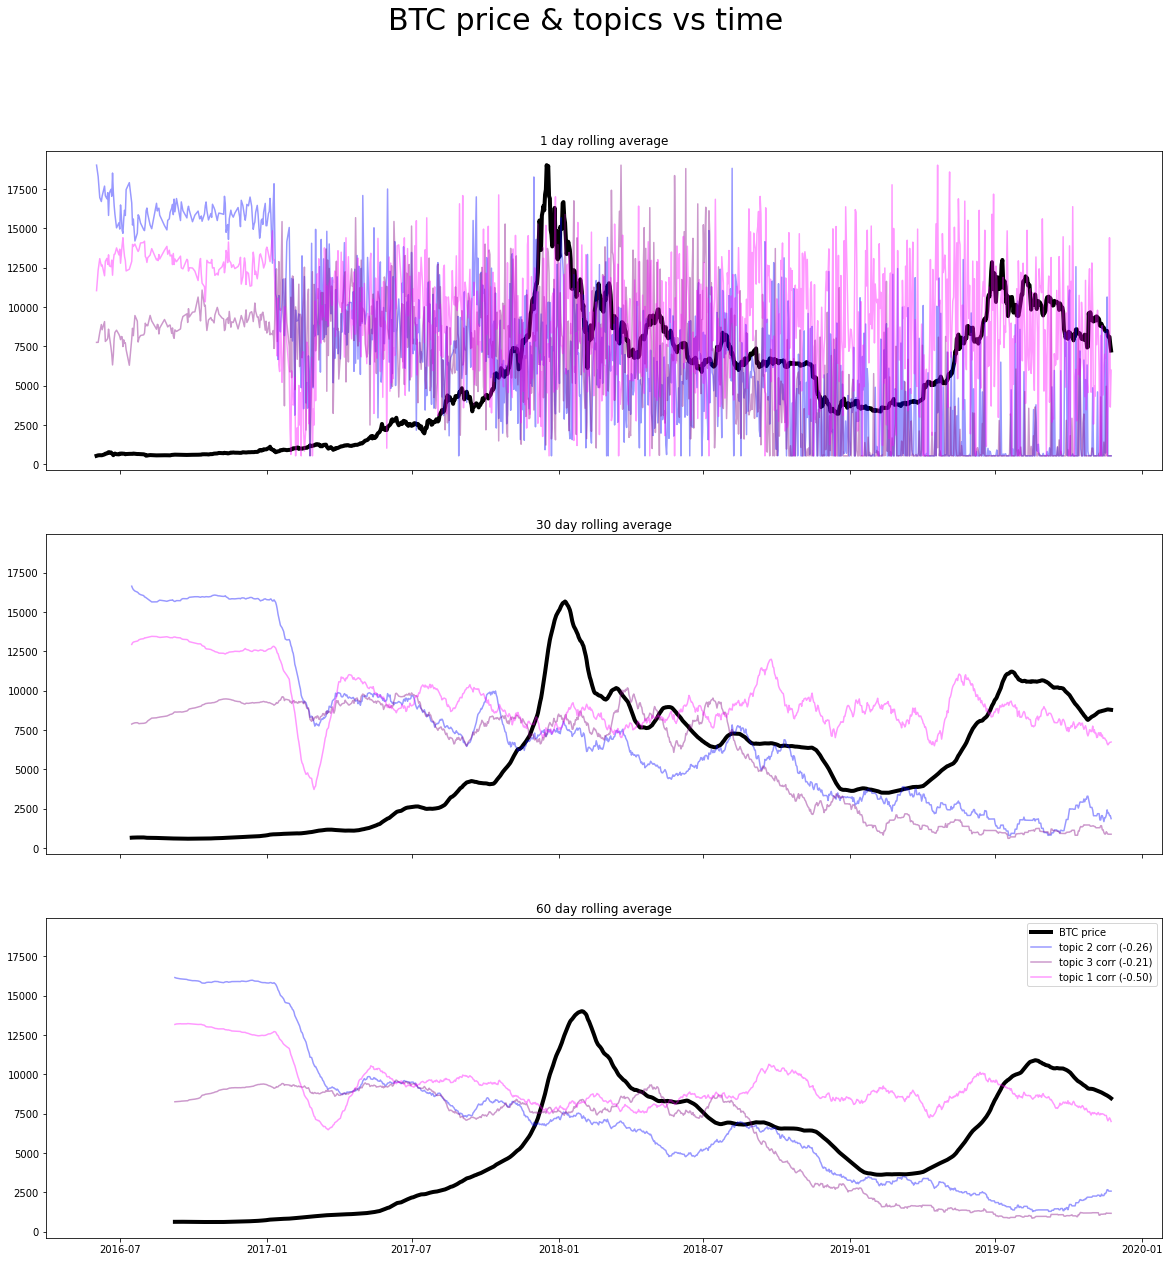

In [10]:
price_analysis(W, H, prices)

In [3]:
# network analysis
# user_score = nx.pagerank(data['user_network'], tol=1e-8, max_iter=200)
_, user_score = nx.hits(data['user_network'], max_iter=500) # output: hubs, authority
total_user_num = len(data['user_network'].nodes())

In [4]:
# 상위 유저 분석!
top_users = sorted(user_score, key=user_score.get, reverse=True)

acc_sum = 0
top_index = 0
score_sum = sum(user_score.values())
for i, top_user in enumerate(top_users):
    acc_sum += user_score[top_user]/score_sum
    if acc_sum > 0.8:
        top_index = i
        break

top_users = top_users[:top_index]
print(f"{top_index} opinion leaders and {len(user_score) - top_index} majority users")

11 opinion leaders and 21517 majority users


In [8]:
time_list = set()
for top_user in top_users:
    time_list.update(data['user_time_posts'][top_user].keys())

time_list = sorted(time_list)
time_list = [t for t in time_list if t>= datetime.datetime(2015, 6, 1).date()]
time_list_dict = {t: i for i, t in enumerate(time_list)}
print(len(time_list))
print(time_list[0], time_list[-1])

368
2015-06-02 2019-11-23


datetime.date(2015, 6, 2)

In [9]:
tdm = np.zeros((len(time_list), len(voca)), dtype=np.float32)
for top_user in top_users:
    for time, posts in data['user_time_posts'][top_user].items():
        if time in time_list_dict:
            for post in posts:
                for word in post:
                    tdm[time_list_dict[time], voca2idx[word]] += 1
                    
tdm = normalize(tdm)

In [51]:
W, H = get_fitted_output(tdm, 10, 'nmf')

368

topic 1 corr (0.84) btc block time price miner value size utc transaction supply 
topic 2 corr (-0.63) price bitcoin latest usd index panies today regulation money call 
topic 3 corr (-0.35) bitcoin now use accepting guide video merchant split start advisor 

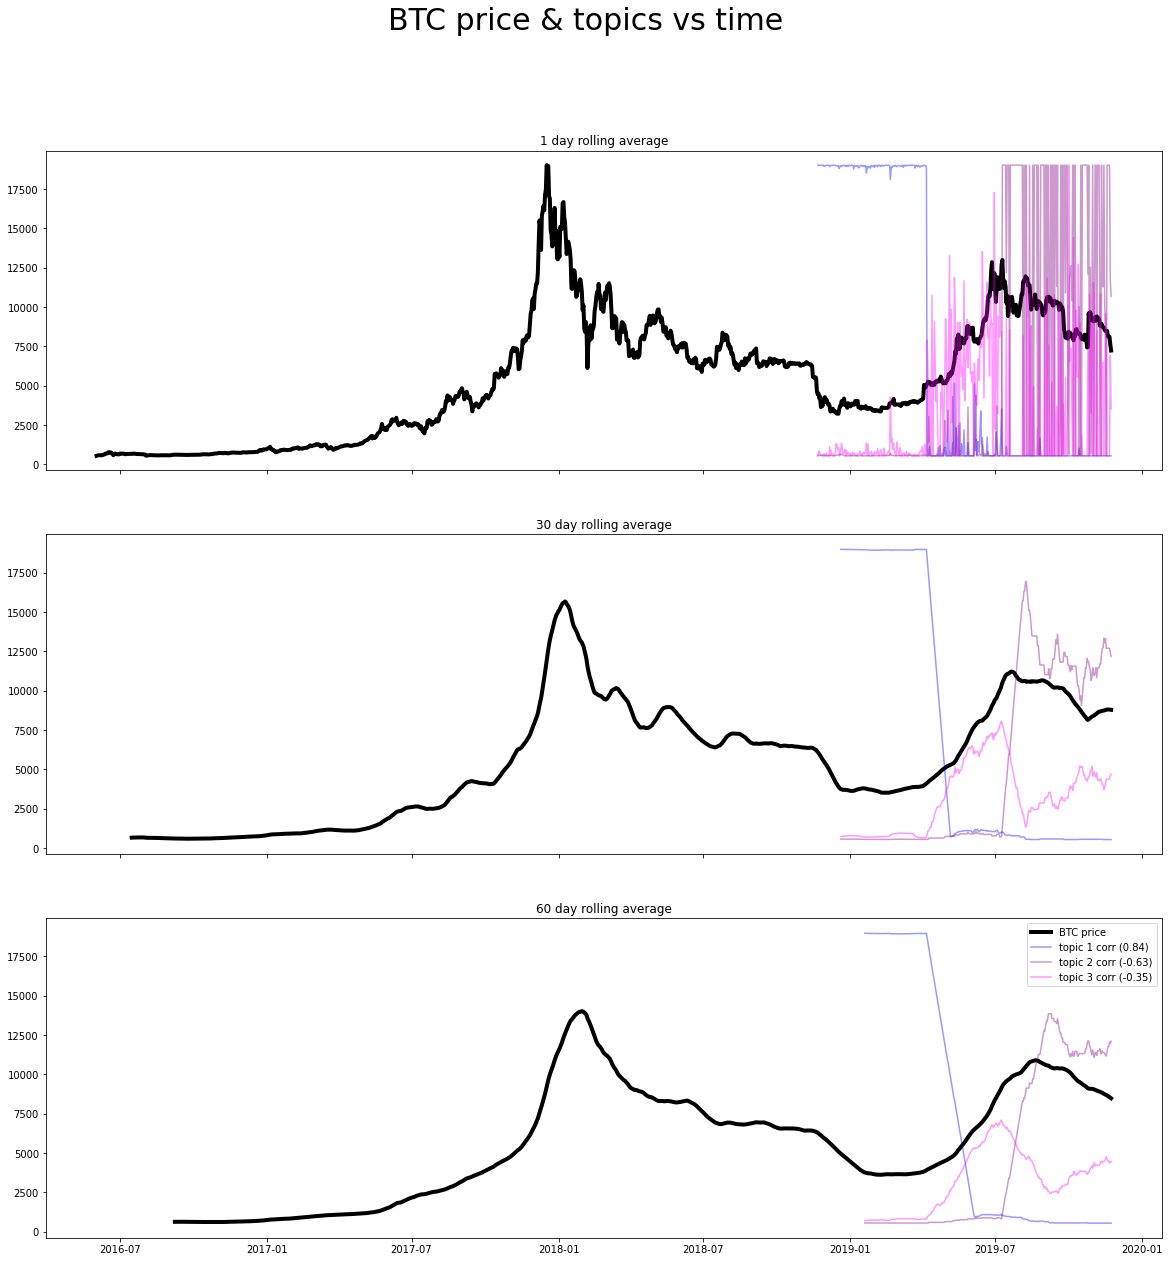

In [52]:
price_analysis(W, H, list(time_list_dict.values()))

In [11]:
K = 10
nmf = NMF(n_components=K, alpha=0.0, max_iter=500)
W = nmf.fit_transform(tdm).T
H = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [15]:
from scipy.stats import pearsonr
prices = np.array([p['high'] for p in prices_list if p['date'] in time_list_dict])
topic_time_correlation = []
for k in range(K):
    topic_time_correlation.append(pearsonr(prices, W[k, :]))
    
topic_time_correlation = np.array(topic_time_correlation) # pearson correlation and p-value
top_topic = np.argsort(np.abs(topic_time_correlation[:,0]))[::-1]

for k in top_topic[:5]:
    print(f"{k+1}th topic, correlation: %f, p-value: %.2e" % (topic_time_correlation[k,0], topic_time_correlation[k,1]))
    for i in H[k, :].argsort()[::-1][:30]:
        print(voca[i], end=' ')
    print()

ValueError: x and y must have the same length.

In [ ]:
from pyecharts import Line
from bokeh.palettes import Set1

line = Line()
for k in  top_topic[:3]:
    line.add(f"topic {k+1}",
             time_list, W[k], is_fill=True, is_stack=True, is_symbol_show=False,
             line_width=0.2, area_opacity=0.4,
             label_color=Set1[7], is_smooth=True, x_axis_type='time')

line.height = 500
line.width = 800
line

In [ ]:
# 하위 유저 분석!
#low_users = sorted(user_score, key=user_score.get, reverse=False)[:int(total_user_num*0.8)]
low_users = sorted(user_score, key=user_score.get, reverse=False)[:-top_index]

In [ ]:
time_list = set()
for low_user in low_users:
    time_list.update(data['user_time_posts'][low_user].keys())

time_list = sorted(time_list)
time_list = [t for t in time_list if t>= datetime(2015, 6, 1).date()]
time_list_dict = {t: i for i, t in enumerate(time_list)}
print(len(time_list))
print(time_list[0], time_list[-1])

735
2015-06-01 2018-02-01


In [ ]:
tdm = np.zeros((len(time_list), len(voca)), dtype=np.float32)
for low_user in low_users:
    for time, posts in data['user_time_posts'][low_user].items():
        if time in time_list_dict:
            for post in posts:
                for word in post:
                    tdm[time_list_dict[time], voca2idx[word]] += 1
                    
tdm = normalize(tdm)

In [ ]:
nmf = NMF(n_components=K, alpha=0.1, max_iter=500)
W = nmf.fit_transform(tdm).T
H = nmf.components_

In [ ]:
from scipy.stats import pearsonr
prices = np.array([p['high'] for p in prices_list if p['date'] in time_list_dict])
topic_time_correlation = []
for k in range(K):
    topic_time_correlation.append(pearsonr(prices, W[k, :]))
    
topic_time_correlation = np.array(topic_time_correlation) # pearson correlation and p-value
top_topic = np.argsort(np.abs(topic_time_correlation[:,0]))[::-1]

for k in top_topic[:5]:
    print(f"{k+1}th topic, correlation: %f, p-value: %.2e" % (topic_time_correlation[k,0], topic_time_correlation[k,1]))
    for i in H[k, :].argsort()[::-1][:30]:
        print(voca[i], end=' ')
    print()

8th topic, correlation: 0.650151, p-value: 1.62e-89
price coin market now bitcoin money currency exchange crypto time year make value bank new cryptocurrency buy day world get country trading sell china long government dollar future usd fork 
0th topic, correlation: 0.491694, p-value: 5.30e-46
bitcoin new currency good idea cash now buy future mining world payment used thanks business satoshi store place get make need day help user network question fork wondering point source 
1th topic, correlation: 0.243260, p-value: 2.32e-11
btc buy day get coin need exchange fork time know coinbase bcc cash got sent trade now owner thanks using usd question last buying around payment send big price trading 
3th topic, correlation: 0.147920, p-value: 5.68e-05
transaction fee time unconfirmed now sent confirmed confirmation hour amount money send network high first take btc pay paid mean small miner dust payment output segwit show example future made 
2th topic, correlation: 0.119618, p-value: 1.16e-

In [ ]:
from pyecharts import Line
from bokeh.palettes import Set1

line = Line()
for k in  top_topic[:3]:
    line.add(f"topic {k+1}",
             time_list, W[k], is_fill=True, is_stack=True, is_symbol_show=False,
             line_width=0.2, area_opacity=0.4,
             label_color=Set1[7], is_smooth=True, x_axis_type='time')

line.height = 500
line.width = 800
line